In [1]:
# =============================================================================
# 
# =============================================================================


# allows to import own functions
import sys
import os
import re
root_project = re.findall(r'(^\S*TFM-master)', os.getcwd())[0]
sys.path.append(root_project)

from scipy.stats import  loguniform
import pandas as pd
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from src.features.add_features import features_graph, features_pop
from src.utils.help_func import results_searchcv, make_train_val_test
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.regressor import ResidualsPlot
import joblib
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Path to save the model
PATH =  f"{root_project}/models/linear_regression_rev17.pkl"

# Read data
df = pd.read_csv(
    f'{root_project}/data/processed/simulation_results_rev17_wide_static.csv')
# Load features
df = features_graph(df)
df = features_pop(df)

# size_data = 20000 # enter  desired subset of data
# df = df.sample(size_data)

# df['total_deceased'] = df['total_deceased'].replace(0,5)

/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
features = [
    'Tr',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_deceased',
    'betweenness',
    'degree',
    'closeness',
    'country_pop']


df = df[features]

X_train_val, y_train_val, X_test, y_test = make_train_val_test(df, out_mode=1)

Train_validation set: (40757, 12)
Test set: (10189, 12)


In [3]:
X_train_val.describe()

,Tr,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,n_closed,react_time,betweenness,degree,closeness,country_pop
count,40757.000000,4.075700e+04,4.075700e+04,40757.000000,4.075700e+04,40757.000000,40757.000000,40757.000000,40757.000000,40757.000000,40757.000000,4.075700e+04
mean,16.088939,2.378935e+06,4.804419e+05,0.271604,-7.573450e+01,2.025349,9.526879,15.489069,0.006655,0.193561,0.439457,3.705079e+07
std,8.065400,2.057435e+07,3.329096e+06,0.415033,1.139212e+04,3.211596,5.762209,8.651087,0.019112,0.190075,0.066073,1.409184e+08
min,2.002059,0.000000e+00,-1.124679e+06,0.000000,-2.076870e+06,0.000000,0.000000,1.000000,0.000000,0.009009,0.296395,1.164600e+04
25%,9.107522,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,5.000000,8.000000,0.000058,0.063063,0.392920,1.136191e+06
50%,16.101771,1.571429e+01,1.950000e+01,0.172414,1.242038e-01,0.818230,10.000000,15.000000,0.000554,0.126126,0.427746,6.982084e+06
75%,23.112889,1.636071e+03,2.050000e+03,0.424419,6.000000e-01,2.810526,15.000000,23.000000,0.003726,0.252252,0.477419,2.626237e+07
max,29.999595,5.045927e+08,8.714938e+07,21.000000,8.960714e+03,71.000000,19.000000,30.000000,0.184702,0.995495,0.634286,1.392730e+09


In [4]:
y_train_val.describe()

count    4.075700e+04
mean     1.938966e+09
std      2.243429e+09
min      0.000000e+00
25%      0.000000e+00
50%      8.434097e+07
75%      4.128409e+09
max      6.678113e+09
Name: total_deceased, dtype: float64

In [5]:
X_train_val.isna().sum()

Tr             0
inf_pow_1      0
inf_pow_2      0
mort_pow_1     0
mort_pow_2     0
mort_pow_3     0
n_closed       0
react_time     0
betweenness    0
degree         0
closeness      0
country_pop    0
dtype: int64

In [6]:
y_train_val.isna().sum()

0

In [11]:
# transf_target = TransformedTargetRegressor(regressor=SGDRegressor(), func=np.log, inverse_func=np.exp)

# pipe = Pipeline([
#     ('preprocess', StandardScaler()),
#     ('estimator', transf_target)
# ])

pipe = Pipeline([
    ('preprocess', StandardScaler()),
    ('estimator', SGDRegressor()),
])

# param_dist = dict(
#     estimator__regressor__loss = ['squared_loss', 'huber'],
#     estimator__regressor__penalty=['l2', 'l1'],
#     estimator__regressor__alpha = loguniform(0.00001, 1)
# )

param_dist = dict(
    estimator__loss = ['squared_loss', 'huber'],
    estimator__penalty=['l2', 'l1'],
    estimator__alpha = loguniform(0.00001, 1)
)

random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   verbose=1, n_iter=100, 
                                   random_state=42, n_jobs=-1)

random_search.fit(X_train_val, y_train_val)


# Prints out useful information about the model
results_searchcv(random_search, X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.2min


Cross-val best score:
0.18643943263204316
Cross-val std:
0.004214011753899934
Best parameters found:
{'estimator__alpha': 0.2729378165037475, 'estimator__loss': 'squared_loss', 'estimator__penalty': 'l2'}
Score in test:
0.1841632911089558
R^2 in test
0.1841632911089558
MAE in test:
1784086604.184498


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.7min finished


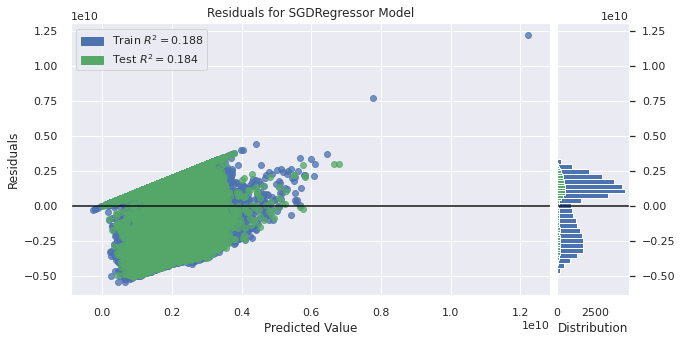

<AxesSubplot:title={'center':'Residuals for SGDRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [18]:
random_search.best_params_

{'estimator__alpha': 0.2729378165037475,
 'estimator__loss': 'squared_loss',
 'estimator__penalty': 'l2'}

In [21]:
df = pd.read_csv(
    f'{root_project}/data/processed/simulation_results_rev17_wide_static.csv')
# Load features
df = features_graph(df)
df = features_pop(df)

df['total_deceased'] = np.log(df['total_deceased'].replace(0, np.finfo(float).eps))


features = [
    'Tr',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_deceased',
    'betweenness',
    'degree',
    'closeness',
    'country_pop']

df = df[features]

X_train_val, y_train_val, X_test, y_test = make_train_val_test(df, out_mode=1)


# pipe = Pipeline([
#     ('preprocess', StandardScaler()),
#     ('estimator', transf_target)
# ])

pipe = Pipeline([
    ('preprocess', StandardScaler()),
    ('estimator', SGDRegressor(alpha=0.2729, loss='squared_loss', penalty='l2')),
])


pipe.fit(X_train_val, y_train_val)

Train_validation set: (40020, 12)
Test set: (10005, 12)


Pipeline(steps=[('preprocess', StandardScaler()),
                ('estimator', SGDRegressor(alpha=0.2729))])

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_prediction = pipe.predict(X_test)
r2_score(y_test, y_prediction)

0.31549448297558635

In [27]:
y_prediction = pipe.predict(X_test)
r2_score(np.exp(y_test), np.exp(y_prediction))

-2.0208010516951907e+106

In [17]:
df['total_deceased']

0       -36.043653
1        21.927124
2        22.320828
3       -36.043653
4        15.439824
           ...    
50020    22.228386
50021     5.192957
50022    22.377521
50023    21.925203
50024    22.403521
Name: total_deceased, Length: 50025, dtype: float64

In [28]:
from sklearn.linear_model import Ridge

In [29]:
df = pd.read_csv(
    f'{root_project}/data/processed/simulation_results_rev17_wide_static.csv')
# Load features
df = features_graph(df)
df = features_pop(df)

features = [
    'Tr',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_deceased',
    'betweenness',
    'degree',
    'closeness',
    'country_pop']

df = df[features]

X_train_val, y_train_val, X_test, y_test = make_train_val_test(df, out_mode=1)

pipe = Pipeline([
    ('preprocess', StandardScaler()),
    ('estimator', Ridge()),
])


param_dist = dict(
    estimator__fit_intercept = [True, False],
    estimator__alpha = loguniform(0.001, 10)
)

random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   verbose=1, n_iter=100, 
                                   random_state=42, n_jobs=-1)

random_search.fit(X_train_val, y_train_val)


# Prints out useful information about the model
results_searchcv(random_search, X_test, y_test)

Train_validation set: (40020, 12)
Test set: (10005, 12)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s


Cross-val best score:
0.16995823162366172
Cross-val std:
0.05989989461090491
Best parameters found:
{'estimator__alpha': 0.0010521761868451127, 'estimator__fit_intercept': True}
Score in test:
0.19471415865490294
R^2 in test
0.19471415865490294
MAE in test:
1721547541.0811586


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.7s finished


In [33]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform

df = pd.read_csv(
    f'{root_project}/data/processed/simulation_results_rev17_wide_static.csv')
# Load features
df = features_graph(df)
df = features_pop(df)

features = [
    'Tr',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_deceased',
    'betweenness',
    'degree',
    'closeness',
    'country_pop']

df = df[features]

X_train_val, y_train_val, X_test, y_test = make_train_val_test(df, out_mode=1)

regr_trans = TransformedTargetRegressor(
    regressor=Ridge(alpha= 0.0010521761868451127),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))


regr_trans.fit(X_train_val, y_train_val)

Train_validation set: (40020, 12)
Test set: (10005, 12)


/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.83691e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


TransformedTargetRegressor(regressor=Ridge(alpha=0.0010521761868451127),
                           transformer=QuantileTransformer(n_quantiles=300,
                                                           output_distribution='normal'))

In [36]:
y_prediction = regr_trans.predict(X_test)
r2_score(y_test, y_prediction)

-0.619694057334296